In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
ad_data = pd.read_csv('data/ad.csv', parse_dates=['timestamp'])

In [3]:
ad_data.head()

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


It turns out that graphing datetime objects is a painful experience, but we can compute the UNIX timestamp of each point for convenience and graph on that number

In [4]:
ad_data['unix'] = (ad_data['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

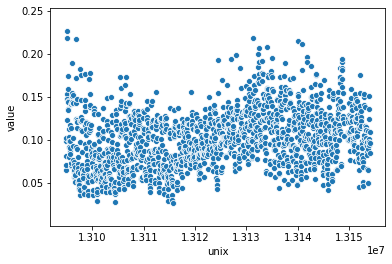

In [5]:
sns.scatterplot(ad_data['unix'], ad_data['value'])

# Feature Engineering

Hour and day of week are fairly obvious features to extract here, as we might expect to see patterns in traffic both on a daily and weekly basis.

Moving average is also a useful feature to engineer.  We can use this to provide context to our algorithms -- points might seem anomalous on their own, but in the context of a surge in usage over the last 60 hours might actually not constitute an anomaly.

Finally, diff is computed as the difference between moving average and actual value, to help models find outliers more easily.

In [6]:
ad_data['hour'] = ad_data['timestamp'].dt.hour
ad_data['day_of_week'] = ad_data['timestamp'].dt.dayofweek

moving_avg_len = 60
ad_data['moving_avg'] = ad_data['value'].rolling(moving_avg_len).sum()
ad_data['moving_avg'] = ad_data['moving_avg'].apply(lambda n: n/60)

ad_data['diff'] = ad_data.apply(lambda r: r['value'] - r['moving_avg'], axis=1)
ad_data['diff'] = ad_data['diff'].fillna(0)

In [7]:
model = IsolationForest()
labels = model.fit_predict(ad_data[['value', 'hour', 'day_of_week', 'diff']])

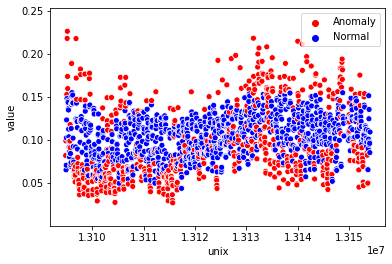

In [8]:
def convert(x):
    if x == 1:
        return "Normal"
    else:
        return "Anomaly"
anomaly_labels = list(map(convert, labels))

colors = {"Normal": "#0000ff", "Anomaly": "#ff0000"}

sns.scatterplot(ad_data['unix'], ad_data['value'], anomaly_labels, palette=colors)

Ok, our isolation forest seems to be isolating, but maybe a bit too much.

In [9]:
anomaly_labels.count('Anomaly') / len(anomaly_labels)

0.3854679802955665

Isolation forests can decide on their own what percentage of points should be considered anomalies, but in this case it appears to be way too sensitive -- above 35% of points labeled as anomalies.  We can reign this in by specifiying the percentage of anomalies, known as 'contamination'.

In [10]:
model = IsolationForest(contamination=.02)
labels = model.fit_predict(ad_data[['value', 'hour', 'day_of_week', 'diff']])

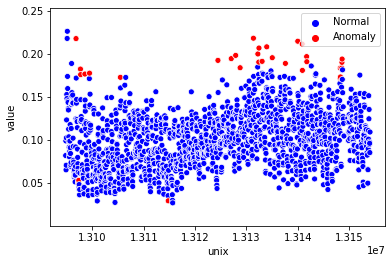

In [11]:
def convert(x):
    if x == 1:
        return "Normal"
    else:
        return "Anomaly"
anomaly_labels = list(map(convert, labels))

colors = {"Normal": "#0000ff", "Anomaly": "#ff0000"}

sns.scatterplot(ad_data['unix'], ad_data['value'], anomaly_labels, palette=colors)

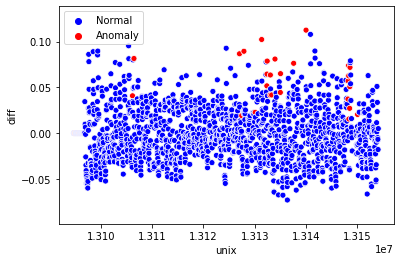

In [16]:
sns.scatterplot(ad_data['unix'], ad_data['diff'], anomaly_labels, palette=colors)

With contamination specified, we get much more reasonable results.  I think the second graph is especially interesting, as it allows some insight into the use of moving average.

In [19]:
model = LocalOutlierFactor(contamination=.02)
labels = model.fit_predict(ad_data[['value', 'hour', 'day_of_week', 'diff']])

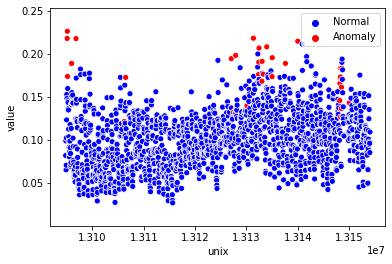

In [20]:
def convert(x):
    if x == 1:
        return "Normal"
    else:
        return "Anomaly"
anomaly_labels = list(map(convert, labels))

colors = {"Normal": "#0000ff", "Anomaly": "#ff0000"}

sns.scatterplot(ad_data['unix'], ad_data['value'], anomaly_labels, palette=colors)

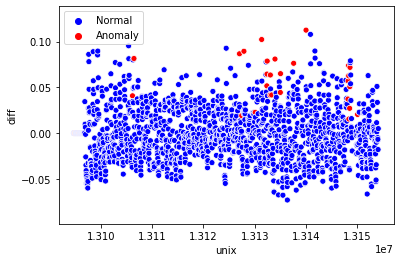

In [21]:
sns.scatterplot(ad_data['unix'], ad_data['diff'], anomaly_labels, palette=colors)

Local Outlier Factor also produced decent results, but did not perform as well as the isolation forest.

# Conclusion

It's worth noting that while this approach was able to produce reasonable results, it has a definite weakness -- it relies on prior knowledge of the percentage of anomalies found in the data.  For real-time detection of errors, such an assumption may prove unworkable.  Other simpler approaches based on statistical methods may prove to be more robust in this context. 